In [14]:
import numpy as np
import pandas as pd

import cv2
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.models import load_model

from imutils import paths
import pathlib
import matplotlib.pyplot as plt
import os
import glob

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import math

pathOfImages = 'C:/Users/hp/Jupyter Notebook Work/Practicum - Face Mask Detection/Dataset/images'
pathOfAnnotations = 'C:/Users/hp/Jupyter Notebook Work/Practicum - Face Mask Detection/Dataset/annotations'

In [15]:
image_path= pathlib.Path(pathOfImages)
annot_path = pathlib.Path(pathOfAnnotations)
image_directories = sorted(glob.glob(os.path.join(image_path,"*.png")))

In [16]:
# Demo of face detection in an image using MTCNN

def demo_detect_face_and_features():
    original_image = cv2.imread(image_directories[0])
    new_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    detected_faces = face_detector.detect_faces(new_image)
    print('')
    print('')
    print('Faces Detected in Image 1: ')
    print(detected_faces)
    print('')
    print('')
    print('Detected Faces and Features:')
    
    for i in range(len(detected_faces)):
        bounding_box = detected_faces[i]['box']
        keypoints = detected_faces[i]['keypoints']

        cv2.rectangle(original_image,
                      (bounding_box[0], bounding_box[1]),
                      (bounding_box[0] + bounding_box[2], bounding_box[1] + bounding_box[3]),
                      (0,155,255),
                      2)

        cv2.circle(original_image,(keypoints['left_eye']), 2, (0,155,255), 2)
        cv2.circle(original_image,(keypoints['right_eye']), 2, (0,155,255), 2)
        cv2.circle(original_image,(keypoints['nose']), 2, (0,155,255), 2)
        cv2.circle(original_image,(keypoints['mouth_left']), 2, (0,155,255), 2)
        cv2.circle(original_image,(keypoints['mouth_right']), 2, (0,155,255), 2)

    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))

In [17]:
# face detector to locate faces in an image at a given confidence minimum
detections = []

def detect(img, imageId, min_confidence):
    
    original_image = cv2.imread(img)
    new_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    detected_faces = face_detector.detect_faces(new_image)
    (im_h, im_w) = original_image.shape[:2]
    
    for detected_face in detected_faces:
        confidence = detected_face['confidence']
        
        if confidence >= min_confidence:
            x, y, w, h = detected_face['box']
            (x, y) = (max(0, x), max(0, y))
            (x2, y2) = (min(im_w - 1, x+w), min(im_h - 1, y+h))
            
            x = math.ceil(int(x) - (0.03 * int(x)))
            y = math.ceil(int(y) - (0.01 * int(y)))
            x2 = math.ceil(int(x2) + (0.03 * int(x2)))
            y2 = math.ceil(int(y2) + (0.05 * int(y2)))
            
            face = new_image[y:y2, x:x2]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = np.expand_dims(face, axis=0)
            face = preprocess_input(face)

            mask_weared_incorrect, with_mask, without_mask = model.predict(face)[0]
           
            if max([mask_weared_incorrect, with_mask, without_mask]) == with_mask:
                label = 'with_mask'
                color = (0, 255, 0)
            elif max([mask_weared_incorrect, with_mask, without_mask]) == without_mask:
                label = 'without_mask'
                color = (0, 0, 255)
            else:
                label = 'mask_worn_incorrectly'
                color = (255, 0, 0)
                
            label = "{}: {:.2f}%".format(label, max([mask_weared_incorrect, with_mask, without_mask]) * 100)# include the probability in the label
            
            cv2.putText(original_image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(original_image, (x, y), (x2, y2), color, 2)

            detections.append([img[62:], label, color, x, y, x2,  y2])

            plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
            plt.grid(None)

In [18]:
# Detect for all the images in the database

def detect_for_all_images():

    for idx,image in enumerate(image_directories):

        original_image = cv2.imread(image)
        imageId = idx

        try:
            detect(image, imageId, 0.5)
        except:
            print(f'error with image {image}')
    
    print('')
    print('Number of face detections: ')
    print(len(detections))

In [19]:
def model_outcome_analysis():
    detections_df = pd.DataFrame(detections, columns=['image', 'label', 'color', 'startX', 'startY', 'endX', 'endY'])
    detection_count = pd.DataFrame(detections_df.groupby('image')['label'].count())
    face_df = pd.read_pickle('4.2.resized_openCV_comparison_dataframe.pkl')
    face_detection_count_df = pd.merge(face_df, detection_count, on='image', how = 'left')
    face_detection_count_df.columns = ['image', 'face_count', 'detected']
    face_detection_count_df.fillna(0, inplace=True)
    face_detection_count_df['diff'] = face_detection_count_df['face_count'] - face_detection_count_df['detected']
    return face_detection_count_df

1/1 [==============================] - 0s 96ms/step


Faces Detected in Image 1: 
[{'box': [77, 100, 28, 36], 'confidence': 0.9973770380020142, 'keypoints': {'left_eye': (87, 114), 'right_eye': (101, 114), 'nose': (95, 121), 'mouth_left': (89, 130), 'mouth_right': (100, 130)}}, {'box': [319, 84, 39, 54], 'confidence': 0.996131420135498, 'keypoints': {'left_eye': (328, 105), 'right_eye': (348, 102), 'nose': (340, 118), 'mouth_left': (332, 127), 'mouth_right': (349, 124)}}, {'box': [459, 170, 25, 28], 'confidence': 0.781191885471344, 'keypoints': {'left_eye': (465, 180), 'right_eye': (474, 176), 'nose': (470, 186), 'mouth_left': (470, 193), 'mouth_right': (478, 190)}}]


Detected Faces and Features:


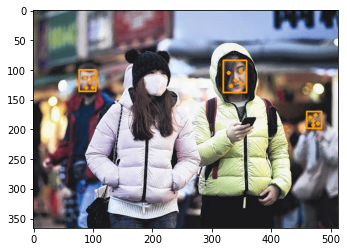

In [20]:
face_detector = MTCNN(min_face_size=13) # Instantiate MTCNN face detector and load in mask detector model
model = load_model('2.2.resized_mobilev2net_detector.h5')

demo_detect_face_and_features()


Testing the detector method:
1/1 [==============================] - 0s 46ms/step


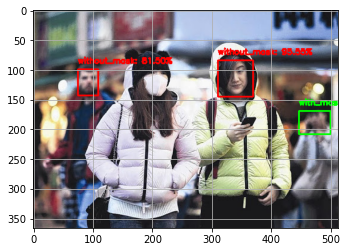

In [21]:
print('')
print('Testing the detector method:')
detect('C:/Users/hp/Jupyter Notebook Work/Practicum - Face Mask Detection/Dataset/images/maksssksksss0.png', 165, 0.5)

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 28ms/step


2/2 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step


8/8 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 12ms/step


5/5 [==============================] - 0s 12ms/step


3/3 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


8/8 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 16ms/step


3/3 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


5/5 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 131ms/step

Number of face detections: 
2724


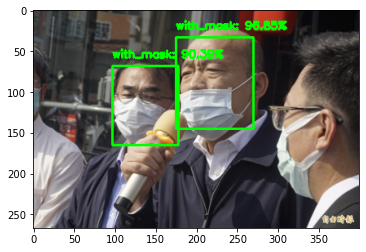

In [22]:
detections = []
detect_for_all_images()

In [27]:
face_detection_count_df = model_outcome_analysis()

print('')
print('Difference in Detection Analysis: ')
face_detection_count_df.sort_values('diff', ascending=False).head()


Difference in Detection Analysis: 


,image,face_count,detected,diff
165,ion\Dataset\images\maksssksksss247.png,13,2.0,11.0
170,ion\Dataset\images\maksssksksss251.png,24,15.0,9.0
468,ion\Dataset\images\maksssksksss52.png,33,26.0,7.0
180,ion\Dataset\images\maksssksksss260.png,32,25.0,7.0
66,ion\Dataset\images\maksssksksss158.png,10,4.0,6.0


In [28]:
print('')
print('Cases were face lesser were detected: ')
face_detection_count_df[face_detection_count_df['diff'] > 0].sum()


Cases were face lesser were detected: 


image         ion\Dataset\images\maksssksksss1.pngion\Datase...
face_count                                                 1659
detected                                                 1104.0
diff                                                      555.0
dtype: object

In [29]:
print('')
print('Cases were face more were detected: ')
face_detection_count_df[face_detection_count_df['diff'] < 0].sum()


Cases were face more were detected: 


image         ion\Dataset\images\maksssksksss104.pngion\Data...
face_count                                                  386
detected                                                  561.0
diff                                                     -175.0
dtype: object

In [30]:
print('')
print('Sorted view of differences: ')
face_detection_count_df[face_detection_count_df['diff'] == 0].sort_values(by='face_count')


Sorted view of differences: 


,image,face_count,detected,diff
355,ion\Dataset\images\maksssksksss418.png,0,0.0,0.0
59,ion\Dataset\images\maksssksksss151.png,0,0.0,0.0
850,ion\Dataset\images\maksssksksss97.png,1,1.0,0.0
358,ion\Dataset\images\maksssksksss420.png,1,1.0,0.0
618,ion\Dataset\images\maksssksksss655.png,1,1.0,0.0
...,...,...,...,...
305,ion\Dataset\images\maksssksksss373.png,13,13.0,0.0
510,ion\Dataset\images\maksssksksss558.png,14,14.0,0.0
321,ion\Dataset\images\maksssksksss388.png,14,14.0,0.0
674,ion\Dataset\images\maksssksksss705.png,16,16.0,0.0
